In [1]:
import pandas as pd

import xgboost as xgb

import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt

from scipy.stats import fisher_exact, chi2_contingency, skew, kurtosis

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, \
    OrdinalEncoder, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('../data/DontGetKicked/training.csv')

In [3]:
categorical_columns = [
    'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
    'VehYear', 'Transmission', 'WheelType', 'Nationality', 'Size', 
    'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST',
    'WheelTypeID', 'VNZIP1', 'IsOnlineSale', 'PurchDate'
]
df[categorical_columns] = df[categorical_columns].astype('category')
numerical_columns = list(set(df.columns) - set(categorical_columns))
target_column =  'IsBadBuy'
numerical_columns.remove(target_column)
df[numerical_columns] = df[numerical_columns].astype('float')

def drop_columns(df, columns):
    df = df.drop(columns=columns)
    for column in columns:
        if column in categorical_columns:
            categorical_columns.remove(column)
        if column in numerical_columns:
            numerical_columns.remove(column)
    return df

def add_categorical_column(df, column, values):
    df[column] = values
    df[column] = df[column].astype('category')
    categorical_columns.append(column)
    return df


def add_numerical_column(df, column, values):
    df[column] = values
    df[column] = df[column].astype('float')
    numerical_columns.append(column)
    return df

def plot_distributions(df, columns):
    num_columns = len(columns)
    columns_per_row = 2
    rows = (num_columns + columns_per_row - 1) // columns_per_row

    fig, axes = plt.subplots(rows, columns_per_row, figsize=(12, rows * 4))
    axes = axes.flatten()

    for index, column in enumerate(df[columns].columns):
        sns.histplot(df[column], kde=True, ax=axes[index])
        axes[index].set_title(f'Distribution of {column}')

    # Remove any extra subplots
    for del_index in range(index + 1, len(axes)):
        fig.delaxes(axes[del_index])

    plt.tight_layout()

In [4]:
df = drop_columns(
    df=df,
    columns=['RefId', 'WheelTypeID', 'BYRNO',
             'VNZIP1', 'SubModel', 'Trim', 'Model',
             'VehYear'
             ]      
)

purchase_month = df['PurchDate'].apply(lambda x: x.split('/')[0])
df = add_categorical_column(df=df, column='PurchMonth', values=purchase_month)
df = drop_columns(df=df, columns=['PurchDate'])

df['WheelType'] = df['WheelType'].apply(lambda x: x.upper())

In [ ]:
numerical_column_ranges = {
    'VehicleAge': (0, 30),
    'VehOdo': (0, 120000),
    'VehBCost': (1000, 46000),
    'WarrantyCost': (400, 8000),
    'MMRAcquisitionAuctionAveragePrice': (800, 46000),
    'MMRAcquisitionAuctionCleanPrice': (1000, 46000),
    'MMRAcquisitionRetailAveragePrice': (1000, 46000),
    'MMRAcquisitonRetailCleanPrice': (1000, 46000),
    'MMRCurrentAuctionAveragePrice': (300, 46000),
    'MMRCurrentAuctionCleanPrice': (400, 46000),
    'MMRCurrentRetailAveragePrice': (800, 46000),
    'MMRCurrentRetailCleanPrice': (1000, 46000)
}

for column, (min_value, max_value) in numerical_column_ranges.items():
    df[column] = df[column].apply(lambda x: x if min_value <= x <= max_value else None)

for column in numerical_columns:
    mean = df[column].mean()
    std = df[column].std()
    if mean != 0:
        cov = std / np.abs(mean)
    else:
        cov = std
    if cov < 0.1:
        drop_columns(df=df, columns=[column])

print(df[numerical_columns].describe())

       MMRAcquisitionAuctionCleanPrice  MMRCurrentAuctionAveragePrice  \
count                     72137.000000                   72164.000000   
mean                       7458.269986                    6174.908306   
std                        2620.271213                    2388.317304   
min                        1076.000000                     369.000000   
25%                        5479.000000                    4312.000000   
50%                        7354.000000                    6088.000000   
75%                        9044.000000                    7745.000000   
max                       36859.000000                   35722.000000   

           VehBCost  MMRAcquisitonRetailCleanPrice  \
count  72981.000000                   72137.000000   
mean    6731.115687                    9963.998766   
std     1767.531058                    3235.506626   
min     1400.000000                    1662.000000   
25%     5435.000000                    7561.000000   
50%     6700.00000

In [6]:
df['Make'] = df['Make'].astype('object').replace({'TOYOTA SCION': 'SCION'}).astype('category')
df['Transmission'] = df['Transmission'].astype('object').replace({'Manual': 'MANUAL'}).astype('category')
df['Color'] = df['Color'].astype('object').replace({'NOT AVAIL': None}).astype('category')

for column in categorical_columns:
    value_counts = df[column].value_counts()
    proba = value_counts / value_counts.sum()
    mask = proba <= 0.01
    replace_dict = {key: 'OTHER' for key in mask[mask].reset_index().iloc[:, 0].to_list()}
    df[column] = df[column].astype('object').replace(replace_dict).astype('category')
    num_other = len(df.loc[df[column] == 'OTHER', column])
    if num_other / len(df[column]) < 0.01:
        df[column] = df[column].astype('object').replace({'OTHER': None}).astype('category')

for column in categorical_columns:
    value_counts = df[column].value_counts()
    proba = value_counts / value_counts.sum()
    if (proba > 0.99).any():
        drop_columns(df=df, columns=[column])

prob_na = df[categorical_columns].isna().sum() / len(df)
mask = prob_na > 0.2
na_columns = mask[mask].reset_index().iloc[:, 0].to_list()
for column in na_columns:
    # p_value = chi2_contingency(pd.crosstab(df[column], df[target_column])).pvalue
    p_value = fisher_exact(pd.crosstab(df[column], df[target_column])).pvalue
    if p_value > 0.01:
        df = drop_columns(df=df, columns=[column])

for column in categorical_columns:
    print(df[column].value_counts())

Auction
MANHEIM    41043
OTHER      17501
ADESA      14439
Name: count, dtype: int64
Make
CHEVROLET     17248
DODGE         12912
FORD          11305
CHRYSLER       8844
PONTIAC        4258
OTHER          2835
KIA            2484
SATURN         2163
NISSAN         2085
HYUNDAI        1811
JEEP           1644
SUZUKI         1328
TOYOTA         1144
MITSUBISHI     1030
MAZDA           979
MERCURY         913
Name: count, dtype: int64
Color
SILVER    14875
WHITE     12123
BLUE      10347
GREY       7887
BLACK      7627
RED        6257
GOLD       5231
GREEN      3194
MAROON     2046
OTHER      1710
BEIGE      1584
Name: count, dtype: int64
Transmission
AUTO      70398
MANUAL     2576
Name: count, dtype: int64
WheelType
ALLOY      36050
COVERS     33004
SPECIAL      755
Name: count, dtype: int64
Nationality
AMERICAN          61028
OTHER ASIAN        8033
TOP LINE ASIAN     3722
Name: count, dtype: int64
Size
MEDIUM         30785
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205

In [7]:
df_iso = df.drop(columns=[target_column]).copy()

for column in categorical_columns:
    df_iso[column] = df_iso[column].fillna(df_iso[column].mode().iloc[0])

for column in numerical_columns:
    df_iso[column] = df_iso[column].fillna(df_iso[column].median())

one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(df_iso[categorical_columns])
df_iso = pd.concat([pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out()), df_iso[numerical_columns].reset_index(drop=True)], axis=1) 

scaler = StandardScaler()
X = scaler.fit_transform(df_iso)

clf = IsolationForest()
outliers = clf.fit_predict(X)

print((outliers == -1).sum() / outliers.shape[0])

df = df.drop(df[outliers == -1].index)

print(df.isna().any(axis=1).sum() / len(df) * 100)

0.004069440828686132
6.2611782186390785


In [8]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

numerical_imputer = SimpleImputer(strategy='median')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

In [ ]:
from itertools import combinations
from sklearn.feature_selection import mutual_info_regression

column_combinations = list(combinations(numerical_columns, 2))
mutual_info_scores = [mutual_info_regression(df[[column_1]].values, df[[column_2]].values.squeeze()) for column_1, column_2 in column_combinations]
columns_mutual_info = sorted([list(columns) + [float(score[0])] for columns, score in zip(column_combinations, mutual_info_scores)], key=lambda x: x[2])

In [58]:
df[columns_mutual_info[0][0:2]].var()

,VehOdo,MMRCurrentAuctionCleanPrice
0,89046.0,8552.0
1,93593.0,9222.0
2,73807.0,5557.0
3,65617.0,2646.0
4,69367.0,4384.0
...,...,...
72978,45234.0,3055.0
72979,71759.0,8132.0
72980,88500.0,9802.0
72981,79554.0,7684.0


In [126]:
# selector = SelectPercentile(score_func=mutual_info_classif, percentile=30)
# mask = selector.fit(df[numerical_columns], df[target_column]).get_support()
# unselected_columns = [column for column, drop in zip(numerical_columns, mask) if not drop]
# df = drop_columns(df=df, columns=unselected_columns)

# encoder = OrdinalEncoder()
# encoder.fit_transform(df[categorical_columns])

# selector = SelectPercentile(score_func=lambda X, y: mutual_info_classif(X, y, discrete_features=True), percentile=30)
# mask = selector.fit(encoder.fit_transform(df[categorical_columns]), df[target_column]).get_support()
# unselected_columns = [column for column, drop in zip(categorical_columns, mask) if not drop]
# df = drop_columns(df=df, columns=unselected_columns)

# df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72953 entries, 0 to 72982
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IsBadBuy                       72953 non-null  int64  
 1   VehicleAge                     72953 non-null  float64
 2   Make                           72953 non-null  object 
 3   WheelType                      72953 non-null  object 
 4   Size                           72953 non-null  object 
 5   MMRCurrentAuctionAveragePrice  72953 non-null  float64
 6   MMRCurrentRetailCleanPrice     72953 non-null  float64
 7   VehBCost                       72953 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 5.0+ MB
None


In [116]:
# plot_distributions(df, numerical_columns)

# for column in df[numerical_columns]:
#     print(f'Column: {column}, Skew: {skew(df[column])}, Kurtosis: {kurtosis(df[column])}')

# # transformer = PowerTransformer()
# transformer = QuantileTransformer(output_distribution='normal')
# df[numerical_columns] = transformer.fit_transform(df[numerical_columns])

# plot_distributions(df, numerical_columns)

<Axes: >

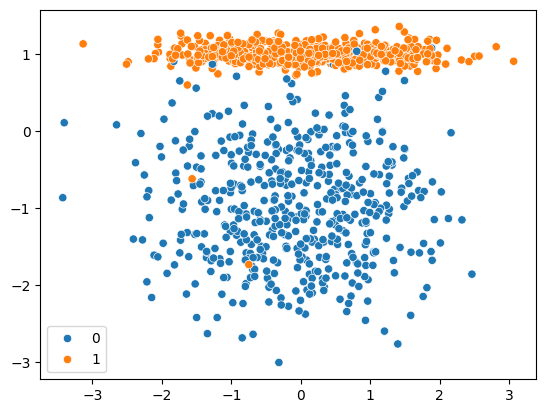

In [20]:
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier


X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=1,
    n_repeated=0,
    n_redundant=0,
    n_clusters_per_class=1
    )

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [ ]:
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# X, y = make_classification(
#     n_samples=1000,
#     n_features=20,
#     n_informative=10,
#     n_repeated=10,
#     n_redundant=0,
#     n_classes=2
#     )
# X, y = make_classification(
#     n_samples=1000,
#     n_features=2,
#     n_informative=2,
#     n_repeated=0,
#     n_redundant=0,
#     n_classes=2
#     )
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=1,
    n_repeated=19,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1
    )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# DecisionBoundaryDisplay.from_estimator(clf, X_test)
# sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# X, y = make_classification(
#     n_samples=1000,
#     n_features=20,
#     n_informative=10,
#     n_repeated=10,
#     n_redundant=0,
#     n_classes=2
#     )
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=20,
    n_repeated=0,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = LogisticRegression(C=np.inf)
# clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.9000
Precision: 0.8862
Recall: 0.9308
F1 Score: 0.9080
AUC: 0.9620


 26%|██▌       | 102/400 [00:18<01:18,  3.77it/s]/opt/homebrew/Caskroom/miniconda/base/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 26%|██▌       | 103/400 [00:18<01:21,  3.62it/s]/opt/homebrew/Caskroom/miniconda/base/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

<Axes: >

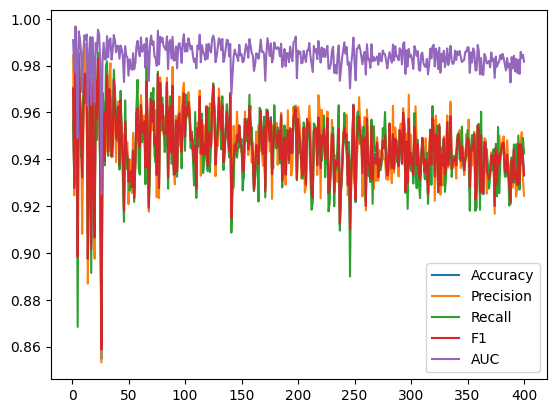

In [74]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


n_samples=10000
n_features=400

accuracy_list = []
precision_list = []
recall_list  = []
f1_list = []
auc_list = []

n_informative_list = list(range(1, n_features+1))

for n_informative in tqdm(n_informative_list):
    # X, y = make_classification(
    #     n_samples=n_samples,
    #     n_features=n_features,
    #     n_informative=n_informative,
    #     n_repeated=n_features - n_informative,
    #     n_redundant=0,
    #     n_classes=2,
    #     n_clusters_per_class=1,
    # )
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_repeated=0,
        n_redundant=n_features - n_informative,
        n_classes=2,
        n_clusters_per_class=1,
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = LogisticRegression(C=np.inf)
    # clf = LogisticRegression()
    # clf = LogisticRegressionCV()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_prob))

df = pd.DataFrame(
    {'Accuracy': accuracy_list,
     'Precision': precision_list,
     'Recall': recall_list,
     'F1': f1_list,
     'AUC': auc_list
    },
    index=n_informative_list
)

df.plot()